<a href="https://colab.research.google.com/github/DingLi23/s2search/blob/pipelining/pipelining/ale-exp1/cslg_1w_ale_plotting.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment Description

1-way ALE.

> This notebook is for experiment \<ale-exp1\> and data sample \<cslg\>.

### Initialization

In [685]:
%load_ext autoreload
%autoreload 2
import numpy as np, sys, os
in_colab = 'google.colab' in sys.modules
# fetching code and data(if you are using colab
if in_colab:
    !rm -rf s2search
    !git clone --branch pipelining https://github.com/youyinnn/s2search.git
    sys.path.insert(1, './s2search')
    %cd s2search/pipelining/pdp-exp1/

pic_dir = os.path.join('.', 'plot')
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading Data

In [686]:
sys.path.insert(1, '../../')
import numpy as np, sys, os
from getting_data import read_conf

sample_name = 'cslg'

f_list = [
    'title', 'abstract', 'venue', 'authors', 
    'year', 
    'n_citations'
    ]
ale_xy = {}

def get_quantile_xlabel(quantile):
    step = 1 / len(quantile) * 100 if len(quantile) > 100 else 1
    lb = 0
    new_quantile = []
    limit = len(quantile)
    while lb < limit:
       new_quantile.append(lb) 
       lb += step
    return new_quantile

for f in f_list:
    file = os.path.join('.', 'scores', f'{sample_name}_1w_ale_{f}.npz')
    if os.path.exists(file):
        nparr = np.load(file)
        quantile = nparr['quantile']
        ale_result = nparr['ale_result']
        values_for_rug = nparr.get('values_for_rug')
        
        ale_xy[f] = {
            'x': quantile,
            'y': ale_result,
            'rug': values_for_rug,
            'weird': ale_result[len(ale_result) - 1] > 20
        }
        
        if f != 'year' and f != 'n_citations':
            ale_xy[f]['x'] = get_quantile_xlabel(quantile)
            ale_xy[f]['numerical'] = False
        else:
            ale_xy[f]['xticks'] = quantile
            ale_xy[f]['numerical'] = True
               
        # print(len(ale_result))
        
des, sample_configs, sample_from_other_exp = read_conf('.')
print(f'The following feature choose quantiles as ale bin size:')
for k in sample_configs['cslg'][0]['quantiles'].keys():
    print(f"\t{k} with {sample_configs['cslg'][0]['quantiles'][k]}% quantile, hence {len(ale_xy[k]['x'])} bins are used")
print(f'The following feature choose fixed amount as ale bin size:')
for k in sample_configs['cslg'][0]['intervals'].keys():
    print(f"\t{k} with {sample_configs['cslg'][0]['intervals'][k]} values, hence {len(ale_xy[k]['x'])} bins are used")

The following feature choose quantiles as ale bin size:
	year with 0.01% quantile, hence 9294 bins are used
	n_citations with 0.01% quantile, hence 9294 bins are used
The following feature choose fixed amount as ale bin size:
	title with 1000 values, hence 93 bins are used
	abstract with 1000 values, hence 93 bins are used
	authors with 1000 values, hence 93 bins are used
	venue with 1000 values, hence 93 bins are used


### Ranker

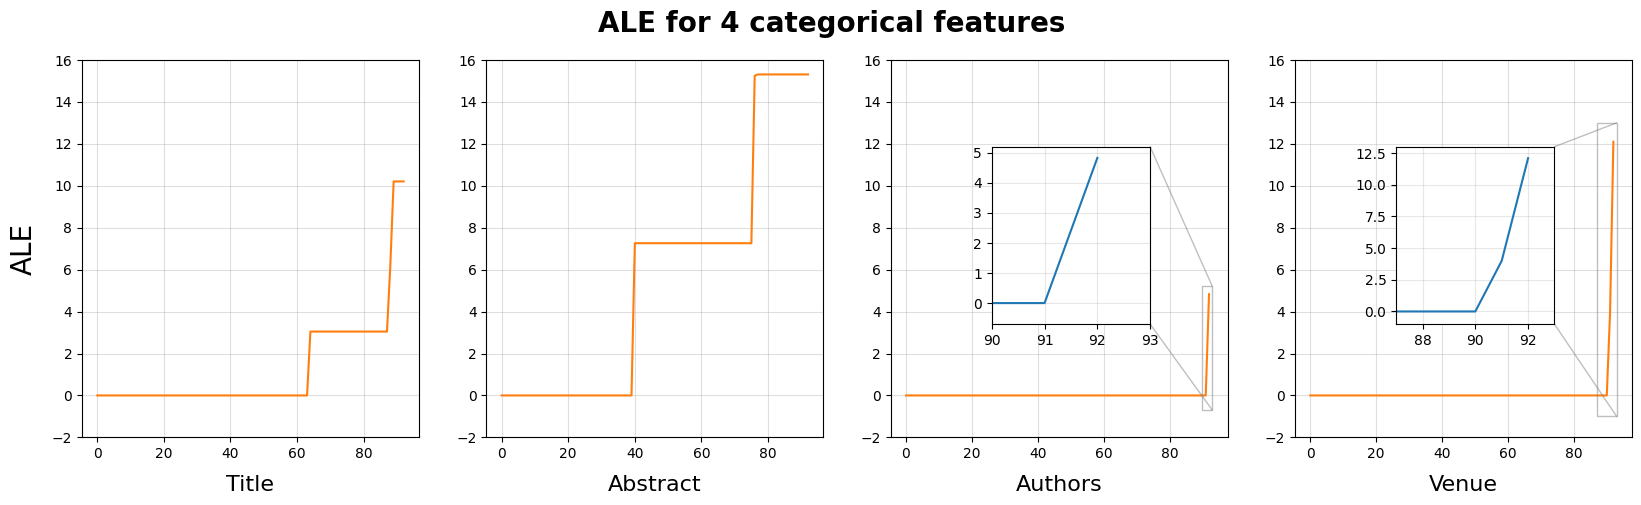

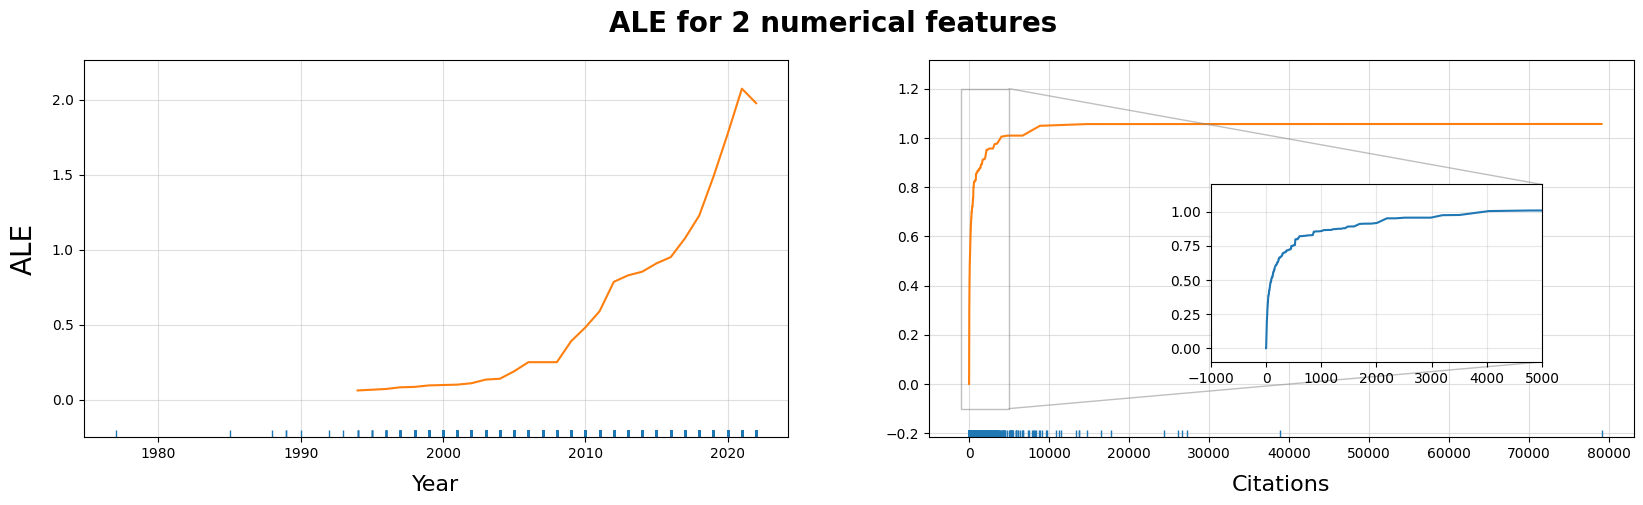

In [687]:
import matplotlib.pyplot as plt
import seaborn as sns


categorical_plot_conf = [
    {
        'xlabel': 'Title',
        'ylabel': 'ALE',
        'ale_xy': ale_xy['title']
    },
    {
        'xlabel': 'Abstract',
        'ale_xy': ale_xy['abstract']
    },    
    {
        'xlabel': 'Authors',
        'ale_xy': ale_xy['authors'],
        'zoom': {
            'inset_axes': [0.3, 0.3, 0.47, 0.47],
            'x_limit': [90, 93],
            'y_limit': [-0.7, 5.2],
        }
    },    
    {
        'xlabel': 'Venue',
        'ale_xy': ale_xy['venue'],
        'zoom': {
            'inset_axes': [0.3, 0.3, 0.47, 0.47],
            'x_limit': [87, 93],
            'y_limit': [-1, 13],
        }
    },
]

numerical_plot_conf = [
    {
        'xlabel': 'Year',
        'ylabel': 'ALE',
        'ale_xy': ale_xy['year'],
        'rug': True
    },
    {
        'xlabel': 'Citations',
        'ale_xy': ale_xy['n_citations'],
        'zoom': {
            'inset_axes': [0.4, 0.2, 0.47, 0.47],
            'x_limit': [-1000.0, 5000],
            'y_limit': [-0.1, 1.2],
        },
    },
]

def pdp_plot(confs, title):
    fig, axes = plt.subplots(nrows=1, ncols=len(confs), figsize=(20, 5), dpi=100)
    subplot_idx = 0
    plt.suptitle(title, fontsize=20, fontweight='bold')
    # plt.autoscale(False)
    for conf in confs:
        axess = axes if len(confs) == 1 else axes[subplot_idx]
        
        sns.rugplot(conf['ale_xy']['rug'], ax=axess, height=0.02)

        axess.plot(conf['ale_xy']['x'], conf['ale_xy']['y'])
        axess.grid(alpha = 0.4)

        # axess.set_ylim([-2, 20])
        xAxis = axess.xaxis
        
        if ('ylabel' in conf):
            axess.set_ylabel(conf.get('ylabel'), fontsize=20, labelpad=10)
        
        # if ('xticks' not in conf['ale_xy'].keys()):
        #     xAxis.set_ticklabels([])

        axess.set_xlabel(conf['xlabel'], fontsize=16, labelpad=10)
        
        if not (conf['ale_xy']['weird']):
            if (conf['ale_xy']['numerical']):
                # axess.set_ylim([-1, 3])
                pass
            else:
                axess.set_ylim([-2, 16])
                
        if 'zoom' in conf:
            axins = axess.inset_axes(conf['zoom']['inset_axes']) 
            axins.plot(conf['ale_xy']['x'], conf['ale_xy']['y'])
            axins.set_xlim(conf['zoom']['x_limit'])
            axins.set_ylim(conf['zoom']['y_limit'])
            axins.grid(alpha=0.3)
            rectpatch, connects = axess.indicate_inset_zoom(axins)
            connects[0].set_visible(False)
            connects[1].set_visible(False)
            connects[2].set_visible(True)
            connects[3].set_visible(True)
            
        subplot_idx += 1

pdp_plot(categorical_plot_conf, f"ALE for {len(categorical_plot_conf)} categorical features")
plt.savefig(os.path.join('.', 'plot', f'{sample_name}-1wale-categorical.png'), facecolor='white', transparent=False, bbox_inches='tight')

pdp_plot(numerical_plot_conf, f"ALE for {len(numerical_plot_conf)} numerical features")
plt.savefig(os.path.join('.', 'plot', f'{sample_name}-1wale-numerical.png'), facecolor='white', transparent=False, bbox_inches='tight')

plt.show()